# Homework 3
# Autor: Antonio Castañares Rodríguez, A20599898
___



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import tensorflow as tf
import tensorflow.keras as keras
import warnings

from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate, Add, Activation, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

from keras import datasets, layers, models

## First problem: *Robust Estimation*

Generate points that belong to a line segment with given parameters (angle and distance from the origin). Test your line generation by creating points for lines with angles between 0 and 90 degrees, and plot the result. The angle refers to the line angle. You need to compute the normal vector n of the line using this angle, and then generating the point using the implicit line equation: n * p - d = 0

In [ ]:
# ------------------------------------------------------------------------------
#       AUXILIARY FUNCTIONS FOR THIS PROBLEM
# ------------------------------------------------------------------------------

# Ignore deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Function to generate points along a line segment given an angle and distance from the origin
def generate_line_points_normal(angle, distance, num_points=100):
    # Convert angle to radians
    angle_rad = np.deg2rad(angle)

    # Compute the normal vector n from the angle: n = [cos(angle), sin(angle)]
    n = np.array([np.cos(angle_rad), np.sin(angle_rad)])

    # Generate points along the line segment using parametric t values
    x = np.linspace(-10, 10, num_points)

    # Compute corresponding y coordinates using the implicit line equation n * p - d = 0
    # where p is the point (x, y) and d is the distance from the origin to the line.
    y = (distance - n[0] * x) / n[1]

    return x, y

# Function to know if a point is above or below the line
def direction(point_x,point_y):
    d = np.array([x[1] - x[0], y[1] - y[0]])
    v = np.array([point_x - x[0], point_y - y[0]])
    cross_product = np.cross(d,v)
    # Calculate the direction of the point from the line
    direction = np.sign(cross_product)
    return direction

# Function to generate noise given a mean and standard deviation
def noise_points_generation(mean,std_dev,num_points = 100):
    noise_x = np.random.normal(mean, std_dev, num_points) # Generate Gaussian noise for x
    noise_y = np.random.normal(mean, std_dev, num_points) # Generate Gaussian noise for y
    return noise_x, noise_y

# Function to introduce outliers to the data
def introduce_outliers(x_points,y_points, num_outliers, num_points=100):
    # Select random indices to become outliers
    outlier_indices = np.random.choice(num_points,num_outliers, replace=False)

    # Shift points perpendicular to the original line by `shift_distance`
    x_noisy_with_outliers = np.copy(x_points)
    y_noisy_with_outliers = np.copy(y_points)

    # Shift outliers randomly in the positive or negative direction
    for indice in outlier_indices:
        random_shift_distance = np.random.uniform(5,10, 1)
        if direction(x_points[indice],y_points[indice]) == 1:
            y_noisy_with_outliers[indice] += random_shift_distance
        else:
            y_noisy_with_outliers[indice] -= random_shift_distance
    return x_noisy_with_outliers, y_noisy_with_outliers, outlier_indices


Generate points that belong to a line segment with given parameters (angle and distance from the origin). Test your line generation by creating points for lines with angles between 0 and 90 degrees, and plot the result. The angle refers to the line angle. You need to compute the normal vector n of the line using this angle, and then generating the point using the implicit line equation: n * p - d = 0

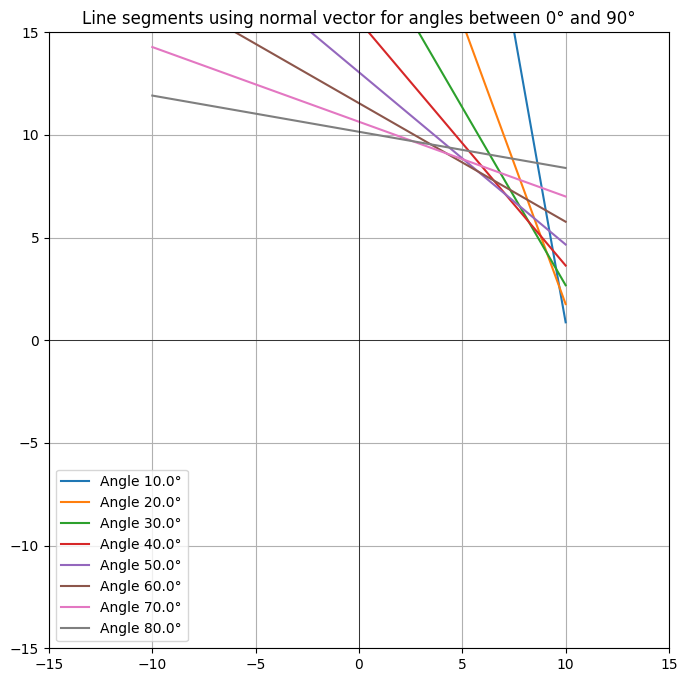

In [ ]:
angles = [i for i in range(10, 81, 10)] # Angles from 0° to 90° in steps of 10°
distance = 10  # Fixed distance from the origin
num_points = 100 # Number of points to generate

plt.figure(figsize=(8, 8))
for angle in angles:
    x, y = generate_line_points_normal(angle, distance, num_points) # Generate line points
    plt.plot(x, y, label=f'Angle {angle:.1f}°') # Plot line segment

# Plotting configuration

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.title('Line segments using normal vector for angles between 0° and 90°')
plt.legend()
plt.grid(True)
plt.show()



Add Gaussian noise with specified mean and standard deviation to the points of a specific line segment, and plot the noisy point. Ensure that the noise is visible.

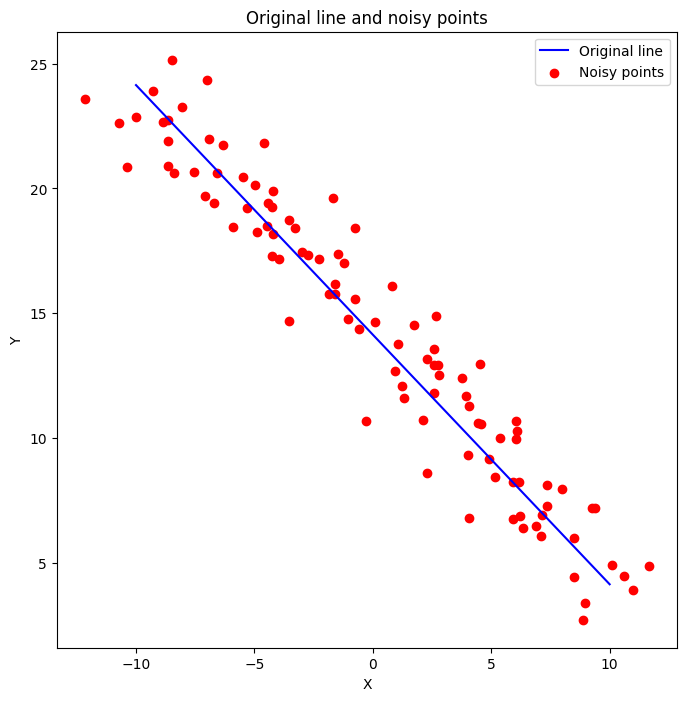

In [ ]:
mean = 0  # Mean of Gaussian noise
std_dev = 1  # Standard deviation of Gaussian noise

# Generate noisy points and obtain the line
noise_x, noise_y = noise_points_generation(mean,std_dev)
x,y = generate_line_points_normal(45, distance, num_points)

# Plot the results
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Original line', color='blue')
plt.scatter(x + noise_x, y + noise_y, label='Noisy points', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original line and noisy points')
plt.legend()
plt.show()


Given the noisy point from the previous step, estimate the parameters of the original line and compute the error compared to the known parameters. Use the cv2.fitLine function to estimate the parameters, utilizing the CV_DIST_L2 distance.

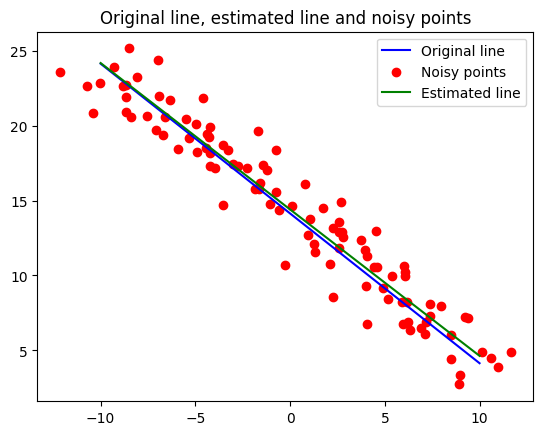

Mean absolute error: 0.27
Error in slope: 1.98
Intercept in the estimated line: 14.409126281738281
Interpretation: Intercept is the point the line crosses the y-axis, 
therefore, it is the value of y when x=0. Watching the plot, the intercept is correct


In [ ]:
# Stack x and y coordinates to form a 2D array of points
points = np.vstack((x + noise_x, y + noise_y)).T

# Fit a line using cv2.fitLine
[vx, vy, x0, y0] = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01).flatten()

# Generate points for the estimated line
slope_estimated = vy / vx
y_estimated = y0 + slope_estimated * (x - x0)
plt.figure()
plt.plot(x, y, label='Original line', color='blue')  # Original line in blue
plt.scatter(x + noise_x, y + noise_y, label='Noisy points', color='red')
plt.plot(x, y_estimated, label='Estimated line', color='green')  # Estimated line in red
plt.title('Original line, estimated line and noisy points')
plt.legend()
plt.show()

# Compute the errors between the original line and the estimated line
errors = np.abs(y - y_estimated)
slope_estimated = vy / vx
slope_original = np.sin(np.deg2rad(45)) / np.cos(np.deg2rad(45))
intercept_estimated = y0 - slope_estimated * x0
print(f'Mean absolute error: {np.mean(errors):.2f}')
print(f'Error in slope: {np.abs(slope_original - slope_estimated):.2f}')
print(f'Intercept in the estimated line: {intercept_estimated}')
print('Interpretation: Intercept is the point the line crosses the y-axis, \n'
      'therefore, it is the value of y when x=0. Watching the plot, the intercept is correct')

Plot a graph showing the error as a function of the noise level.

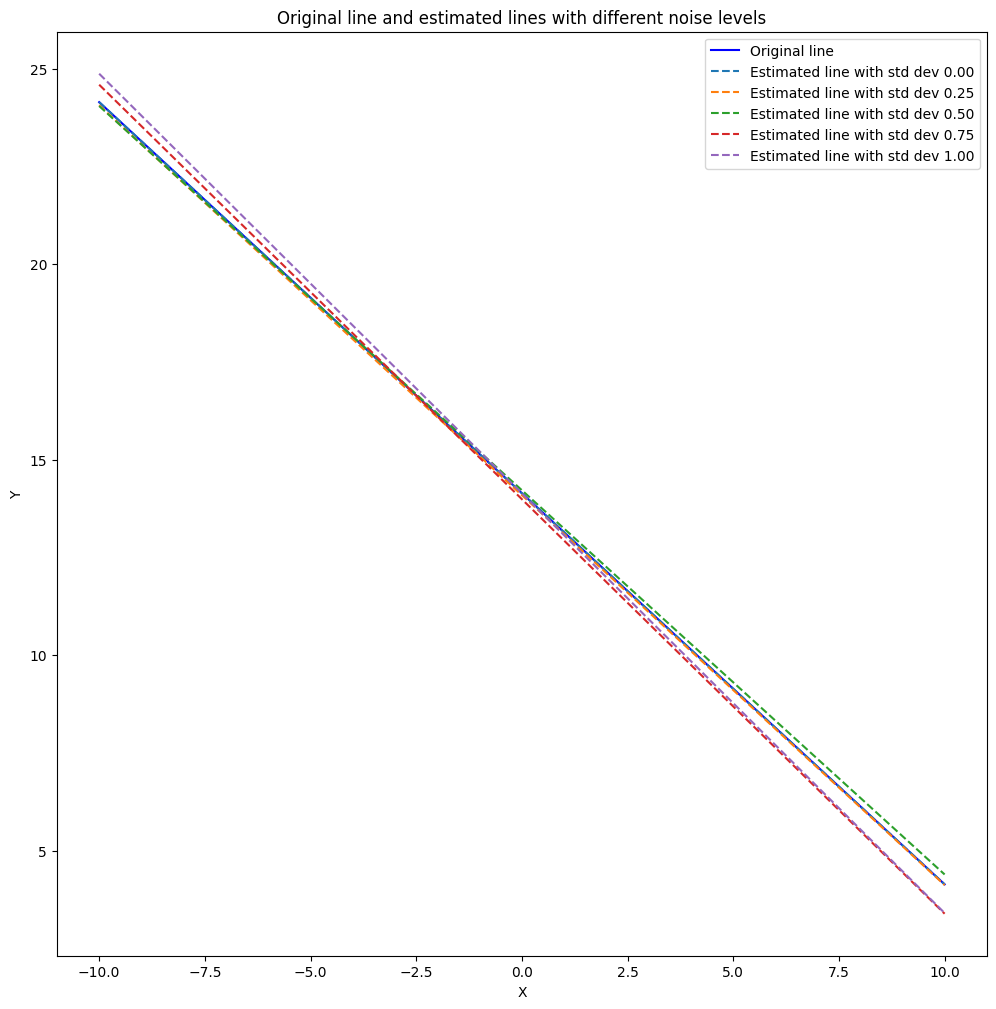

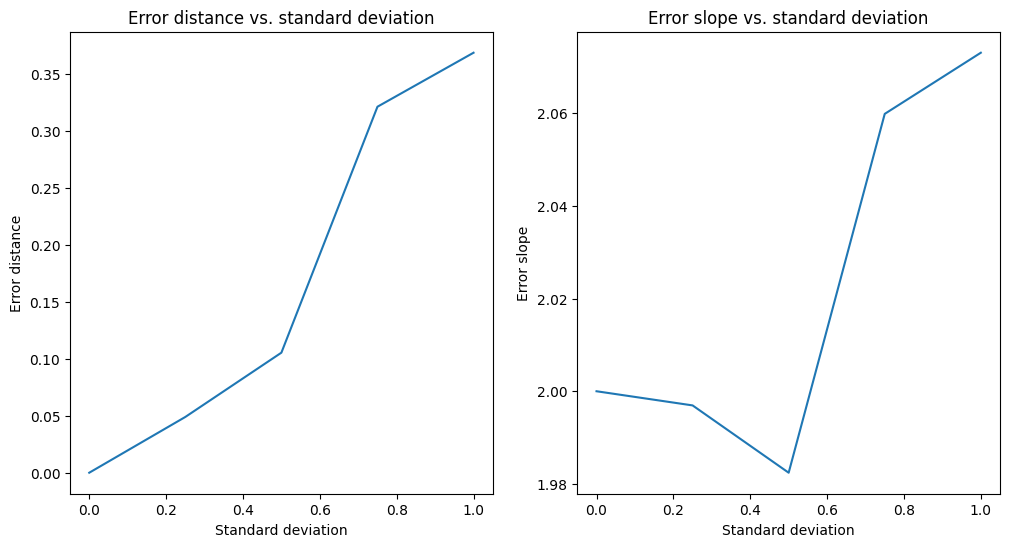

In [ ]:
noise_levels = np.linspace(0, 1, 5)  # [0, 0.25, 0.5, 0.75, 1]
errors = []

plt.figure(figsize=(12,12))
plt.plot(x, y, label='Original line', color='blue')  # Original line in blue
# We have 5 different levels of noise, we will plot the estimated line for each level
for level in noise_levels:
    # Calculate the noise points and estimate the line
    noise_x, noise_y = noise_points_generation(mean,level)
    points = np.vstack((x + noise_x, y + noise_y)).T
    [vx, vy, x0, y0] = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01).flatten()
    plt.plot(x, y0 + vy / vx * (x - x0), label=f'Estimated line with std dev {level:.2f}', linestyle='--')
    slope_estimated = vy / vx
    y_estimated = y0 + slope_estimated * (x - x0)
    error_distance = np.mean(np.abs(y - y_estimated))
    error_slope = np.abs(slope_original - slope_estimated)
    errors.append((level,error_distance, error_slope))

plt.legend()
plt.title('Original line and estimated lines with different noise levels')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

df_errors = pd.DataFrame(errors, columns=['Std dev','Error distance', 'Error slope'])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df_errors['Std dev'], df_errors['Error distance'], label='Error distance')
plt.xlabel('Standard deviation')
plt.ylabel('Error distance')
plt.title('Error distance vs. standard deviation')
plt.subplot(1, 2, 2)
plt.plot(df_errors['Std dev'], df_errors['Error slope'], label='Error slope')
plt.xlabel('Standard deviation')
plt.ylabel('Error slope')
plt.title('Error slope vs. standard deviation')
plt.show()



Introduce a percentage of outliers to the point set and re-estimate the line parameters. Plot the error as a function of the percentage of outliers.

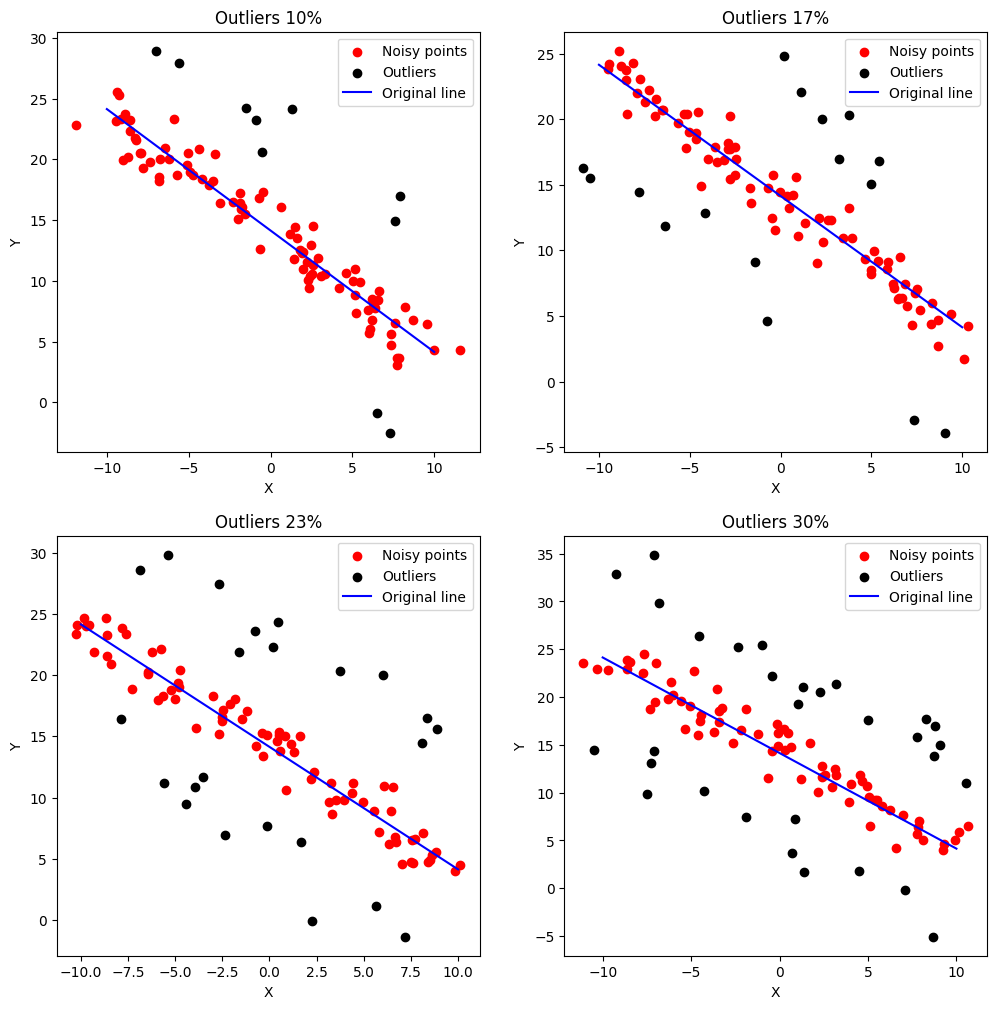

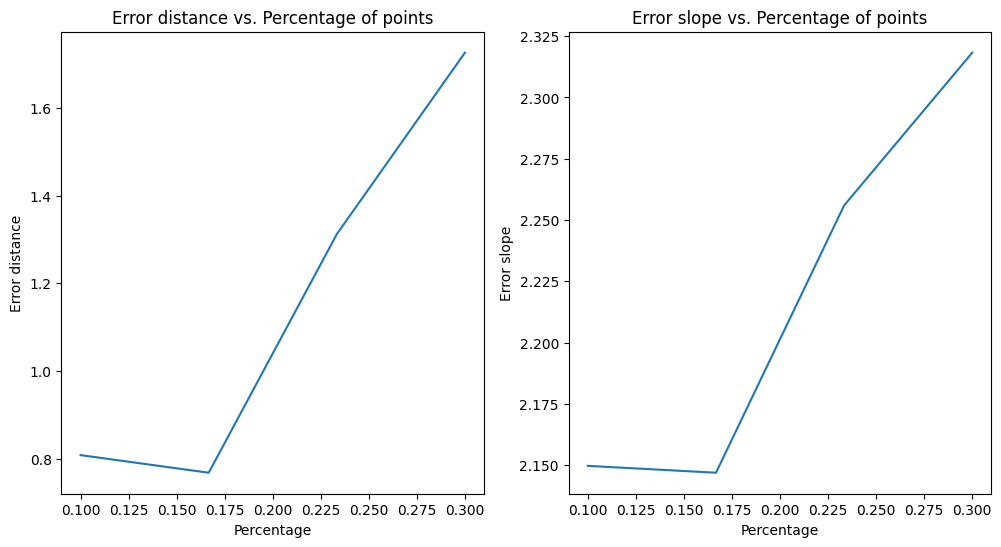

In [ ]:
def estimation_outliers(distance):
    outliers = np.linspace(0.1, 0.3, 4)  # [0.1, 0.16, 0.23, 0.3]
    errors = []
    aux = 1
    plt.figure(figsize=(12,12))
    for percentage in outliers:
        plt.subplot(2, 2, aux)
        # Calculate the noise points
        noise_x, noise_y = noise_points_generation(mean,std_dev)
        noise_x += x
        noise_y += y
        # Introduce outliers
        points_x, points_y, indices = introduce_outliers(noise_x,noise_y,int(num_points * percentage))

        # Re-calculate the line
        points = np.vstack((points_x, points_y)).T
        [vx, vy, x0, y0] = cv2.fitLine(points, distance, 0, 0.01, 0.01).flatten()
        # Obtain main characteristics of the line
        slope_estimated = vy / vx
        y_estimated = y0 + slope_estimated * (x - x0)
        error_distance = np.mean(np.abs(y - y_estimated))
        error_slope = np.abs(slope_original - slope_estimated)
        errors.append((percentage,error_distance, error_slope))

        # Classify between noise points and outliers
        outliers_x = points_x[indices]
        outliers_y = points_y[indices]
        noise_points_x = np.delete(points_x, indices)
        noise_points_y = np.delete(points_y, indices)
        # Plotting
        plt.scatter(noise_points_x, noise_points_y, label='Noisy points', color='red')
        plt.scatter(outliers_x, outliers_y, label='Outliers', color='black')
        plt.plot(x, y, label='Original line', color='blue')  # Original line in blue
        plt.title(f'Outliers {percentage * 100:.0f}%')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        aux += 1
    plt.show()

    df_errors = pd.DataFrame(errors, columns=['Percentage','Error distance', 'Error slope'])
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(df_errors['Percentage'], df_errors['Error distance'], label='Error distance')
    plt.xlabel('Percentage')
    plt.ylabel('Error distance')
    plt.title('Error distance vs. Percentage of points')
    plt.subplot(1, 2, 2)
    plt.plot(df_errors['Percentage'], df_errors['Error slope'], label='Error slope')
    plt.xlabel('Percentage')
    plt.ylabel('Error slope')
    plt.title('Error slope vs. Percentage of points')
    plt.show()

estimation_outliers(cv2.DIST_L2)

Use the cv2.fitLine function for robust line estimation, utilizing the CV_DIST_HUBER distance. Plot the error as a function of the percentage of outliers.

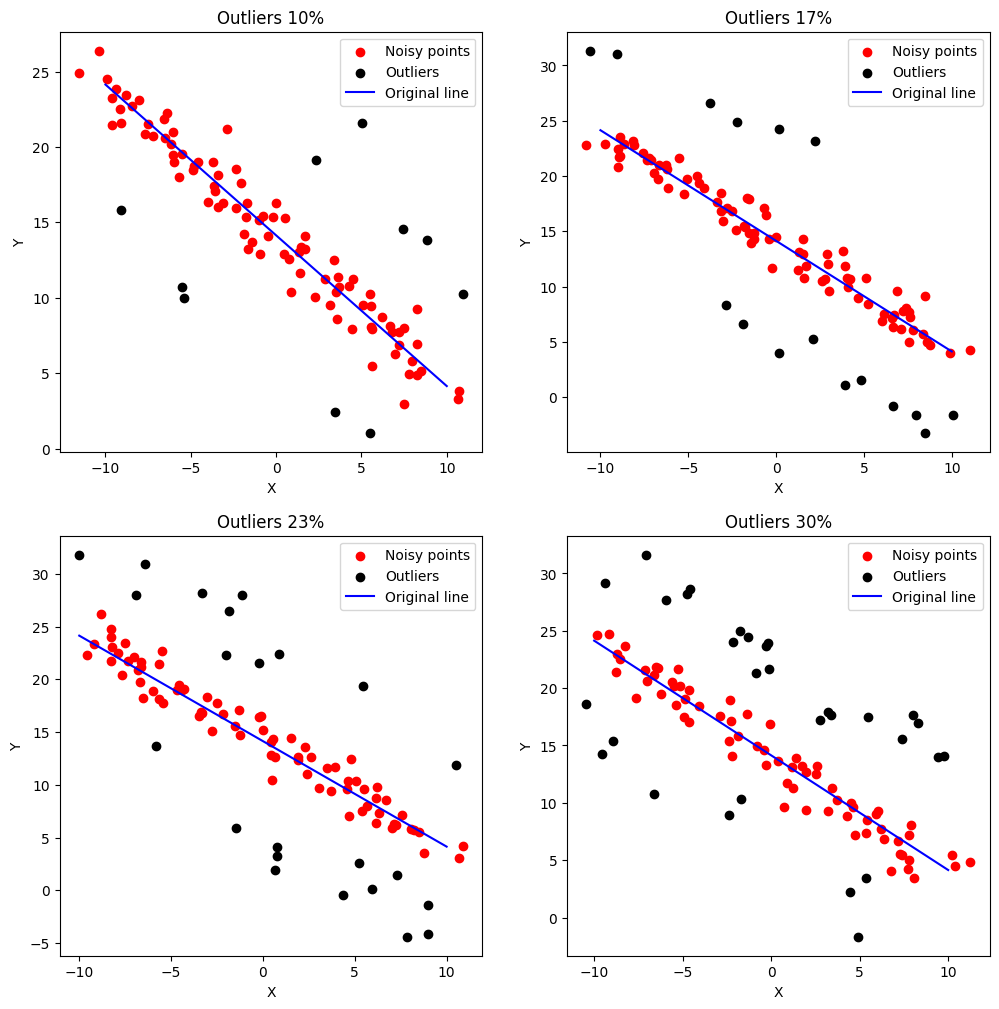

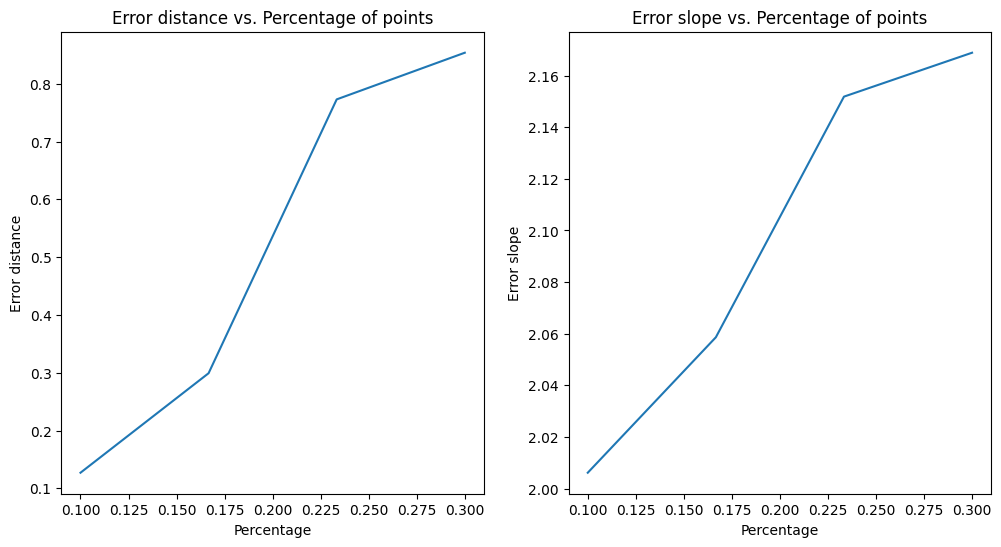

In [ ]:
estimation_outliers(cv2.DIST_HUBER)

Evaluate the algorithm and report results.

The algorithm seems work correctly. Its correctness will depend on the noise points. In addition, the results show that the higher the percentage of outliers, the higher the error. For example, if the percentage of outliers is 30%, the error exceeds 0.8 in distance and 2.16 degrees in slope. Meanwhile, if the outliers represent only 10% of the noise points, these errors are less than 0.2 and 2.02 respectively. Another conclusion is CV_DIST_HUBER works better than the another because its errors are lower.

In summary, more outliers are added, the error consistently grows.

## Second problem: *Image Classification*

Download the Kaggle Cats and Dogs dataset and select a subset of 2.000 dog images and 2.000 cat images for training, validation, and testing. The reduced dataset simulates the condition of limited data.

Number of NaN values:
filename    0
label       0
dtype: int64

Number of duplicated values: 0
Number of images: 4000

Number of cats: 2000
Number of dogs: 2000


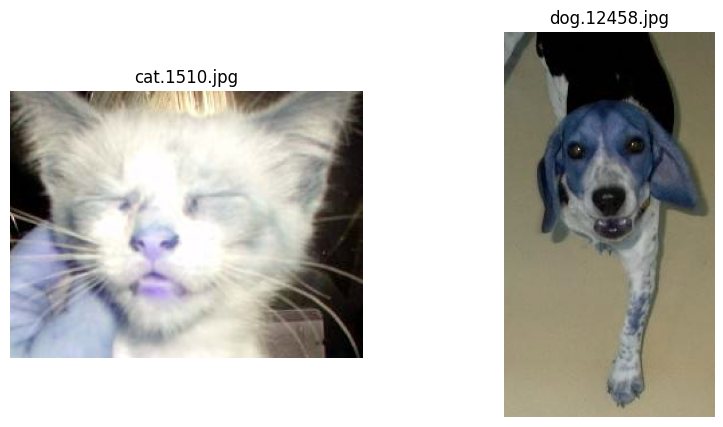

,filename,label
0,cat.5852.jpg,cat
1,cat.1857.jpg,cat
2,cat.5085.jpg,cat
3,cat.7860.jpg,cat
4,cat.7380.jpg,cat
...,...,...
3990,dog.2839.jpg,dog
3991,dog.5781.jpg,dog
3992,dog.5402.jpg,dog
3993,dog.657.jpg,dog


In [ ]:
# Load the images and store them in a DataFrame
# This dataset merge both kind of images into an one folder (I got problems with the original one
# flow_from_dataset does not accepto two directories)
folder = '/content/drive/MyDrive/IIT/Computer Vision/Assignments/Third Assignment/PetImages/train/'

train = os.listdir(folder)

df_aux = pd.DataFrame(columns=['filename', 'label'])
for picture in train:
  if picture.split('.')[0] == 'cat':
    df_aux = pd.concat([df_aux, pd.DataFrame({'filename': [picture], 'label': ['cat']})], ignore_index=True)
  else:
    df_aux = pd.concat([df_aux, pd.DataFrame({'filename': [picture], 'label': ['dog']})], ignore_index=True)

# Select a subset of 2.000 cats and 2.000 dogs
cats_sampled = df_aux[df_aux['label'] == 'cat'].sample(n=2000)
dogs_sampled = df_aux[df_aux['label'] == 'dog'].sample(n=2000)

df = pd.concat([cats_sampled, dogs_sampled], ignore_index=True)

# ------------------------------------------------------------------------------
#       VALIDATIONS
# ------------------------------------------------------------------------------

print(f'Number of NaN values:\n{df.isna().sum()}\n')
print(f'Number of duplicated values: {df.duplicated().sum()}')
print(f'Number of images: {len(df)}\n')

print(f'Number of cats: {len(df[df["label"] == "cat"])}')
print(f'Number of dogs: {len(df[df["label"] == "dog"])}')

# Select and cat and dog random to visualize
cat_random = df[df['label'] == 'cat'].sample(n=1).iloc[0]['filename']
dog_random = df[df['label'] == 'dog'].sample(n=1).iloc[0]['filename']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(folder+cat_random)) # Display a random cat image
plt.title(cat_random)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(folder+dog_random)) # Display a random dog image
plt.title(dog_random)
plt.axis('off')
plt.show()

df.head(-5)

Training samples: 3200
          filename label
54    cat.2837.jpg   cat
169    cat.798.jpg   cat
851   cat.7728.jpg   cat
3011  dog.3915.jpg   dog
576   cat.9551.jpg   cat

Validation samples: 400
           filename label
3077   dog.1492.jpg   dog
3642   dog.6594.jpg   dog
3460  dog.10373.jpg   dog
3004  dog.10826.jpg   dog
639    cat.3239.jpg   cat

Testing samples: 400
           filename label
1334   cat.5759.jpg   cat
845    cat.5981.jpg   cat
3062   dog.2948.jpg   dog
1464   cat.6542.jpg   cat
1047  cat.11679.jpg   cat 



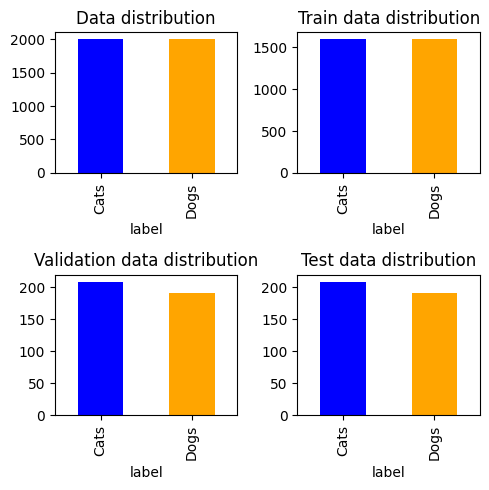

In [ ]:
# Split the dataset (80% train, 10% validation, 10% test)
train_data, temp_data = train_test_split(df, test_size=0.2)
val_data, test_data = train_test_split(temp_data, test_size=0.5)

# ------------------------------------------------------------------------------
#       VALIDATIONS
# ------------------------------------------------------------------------------

# Print the number of samples in each dataset and display the first 5 rows
print(f"Training samples: {len(train_data)}")
print(train_data.head())
print(f"\nValidation samples: {len(val_data)}")
print(val_data.head())
print(f"\nTesting samples: {len(test_data)}")
print(test_data.head(),'\n')

# Plot the distribution of the datasets
plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
df['label'].value_counts().plot.bar(color=['blue', 'orange'])
plt.title('Data distribution')
plt.xticks([0, 1], ['Cats', 'Dogs'])
plt.subplot(2, 2, 2)
train_data['label'].value_counts().plot.bar(color=['blue', 'orange'])
plt.title('Train data distribution')
plt.xticks([0, 1], ['Cats', 'Dogs'])
plt.subplot(2, 2, 3)
val_data['label'].value_counts().plot.bar(color=['blue', 'orange'])
plt.title('Validation data distribution')
plt.xticks([0, 1], ['Cats', 'Dogs'])
plt.subplot(2, 2, 4)
test_data['label'].value_counts().plot.bar(color=['blue', 'orange'])
plt.title('Test data distribution')
plt.xticks([0, 1], ['Cats', 'Dogs'])
plt.tight_layout()
plt.show()


Build a convolution neural network (CNN) with several convolution, pooling, and normalization layers, followed by one or more dense layers. Flatten the output between the convolution and dense layers. Evaluate the model's performance on the validation set.

In [ ]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25)) # Drop 25% to avoid overfitting

# Second convolutional layer (64 filters instead 32)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Third convolutional layer (128 filters instead 64)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Fourth convolutional layer (128 filters)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Flatten the output between the convolutions and dense layers
model.add(Flatten())

# Dense layer with 512 units
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid')) # 1 for binary classification

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,456,577 (13.19 MB)

 Trainable params: 3,454,849 (13.18 MB)

 Non-trainable params: 1,728 (6.75 KB)

Found 3200 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Train_generator -> Number of cats: 1600 and number of dogs: 1600. In total: 3200
Filenames of train_generator:  ['cat.2837.jpg', 'cat.798.jpg', 'cat.7728.jpg', 'dog.3915.jpg', 'cat.9551.jpg', 'dog.107.jpg', 'cat.10829.jpg', 'cat.4072.jpg', 'dog.1484.jpg', 'cat.4916.jpg', 'dog.8388.jpg', 'cat.4697.jpg', 'dog.12189.jpg', 'dog.1099.jpg', 'cat.339.jpg', 'dog.9120.jpg', 'dog.11172.jpg', 'cat.10227.jpg', 'cat.8130.jpg', 'cat.11373.jpg', 'cat.5121.jpg', 'dog.7351.jpg', 'cat.11561.jpg', 'dog.8169.jpg', 'dog.4791.jpg', 'cat.422.jpg', 'cat.1368.jpg', 'cat.8052.jpg', 'dog.5673.jpg', 'cat.3695.jpg', 'cat.5736.jpg', 'dog.10426.jpg', 'cat.6618.jpg', 'dog.775.jpg', 'cat.7180.jpg', 'dog.1052.jpg', 'dog.4700.jpg', 'cat.7717.jpg', 'dog.8578.jpg', 'cat.5041.jpg', 'dog.10572.jpg', 'cat.5099.jpg', 'cat.26.jpg', 'dog.12022.jpg', 

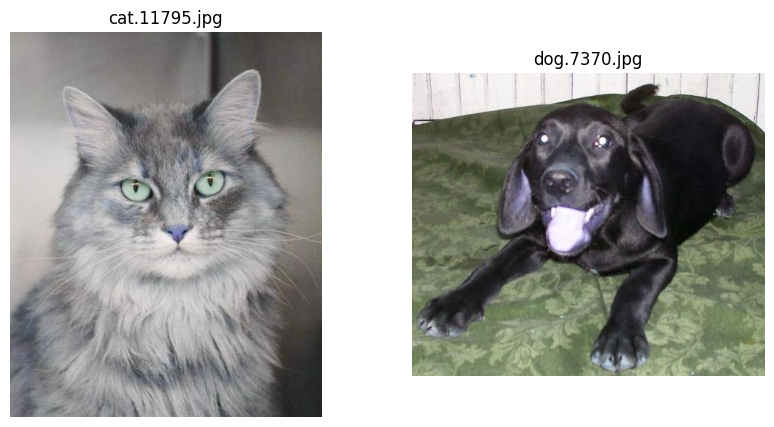

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the data for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=folder,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'     # Since it's binary classification (cats vs dogs)
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=folder,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=folder,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# ------------------------------------------------------------------------------
#       VALIDATIONS
# ------------------------------------------------------------------------------
num_zeros = sum([1 for label in train_generator.labels if label == 0])
num_ones = sum([1 for label in train_generator.labels if label == 1])

print(f"Train_generator -> Number of cats: {num_zeros} and number of dogs: {num_ones}. In total: {num_zeros+num_ones}")
print("Filenames of train_generator: ", train_generator.filenames)
print("Labels of train_generator: ", train_generator.labels)

# Create a dataframe in order to check if it constains cats and dogs correctly
df_train = pd.DataFrame({'filename': train_generator.filenames, 'label': train_generator.labels})
print(df_train.head())

# Select a cat and dog of the train_generator
cat_random = df_train[df_train['label'] == 0].sample(n=1).iloc[0]['filename']
dog_random = df_train[df_train['label'] == 1].sample(n=1).iloc[0]['filename']

# Visualize the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(folder+cat_random)) # Display a random cat image
plt.title(cat_random)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(folder+dog_random)) # Display a random dog image
plt.title(dog_random)
plt.axis('off')
plt.show()

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
)

Number of training images: 3200
Number of validation images: 400
Number of train data: 3200
Number of validation data: 400
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8056 - loss: 0.4154 - val_accuracy: 0.7200 - val_loss: 0.5472
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8263 - loss: 0.3772 - val_accuracy: 0.7100 - val_loss: 0.6848
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.8564 - loss: 0.3243 - val_accuracy: 0.8025 - val_loss: 0.5393
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.8713 - loss: 0.2858 - val_accuracy: 0.7850 - val_loss: 0.6324
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.8878 - loss: 0.2714 - val_accuracy: 0.7775 - val_loss: 0.5662


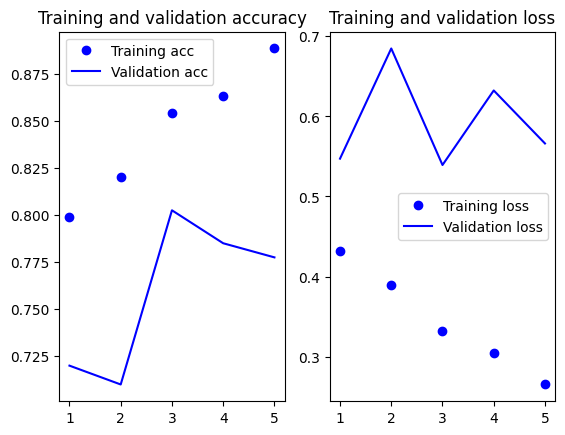

In [ ]:
def results_model():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  # Plot accuracy
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

results_model()

Modify the data generator to include data augmentation, and evaluate the performance on the validation set again.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=folder,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'     # Since it's binary classification (cats vs dogs)
)

Found 3200 validated image filenames belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.6913 - loss: 0.6668 - val_accuracy: 0.7400 - val_loss: 0.7980
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.7184 - loss: 0.5748 - val_accuracy: 0.7225 - val_loss: 0.5615
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7314 - loss: 0.5206 - val_accuracy: 0.7225 - val_loss: 0.5534
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.7349 - loss: 0.5419 - val_accuracy: 0.7775 - val_loss: 0.4897
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.7596 - loss: 0.5084 - val_accuracy: 0.7825 - val_loss: 0.4793


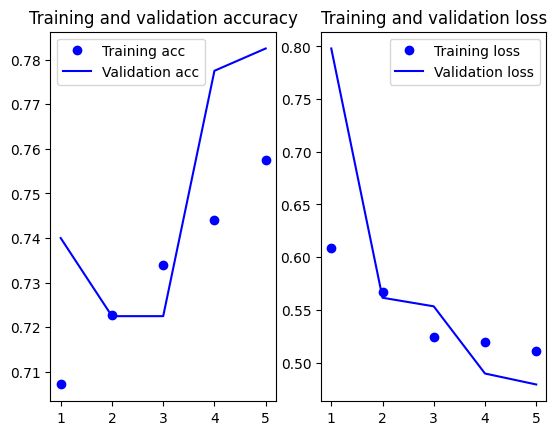

In [ ]:
results_model() # Obtain results

Replace the convolution layers with a pre-trained VGG16 convolutional base, and evaluate the model's performance on the validation set.

In [ ]:
modelVGG16 = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

preds = modelVGG16.predict(validation_generator)

13/13 ━━━━━━━━━━━━━━━━━━━━ 131s 10s/step


Evaluate the algorithm and report results

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 839ms/step - accuracy: 0.8514 - loss: 0.4239
Test Accuracy: 85.00%


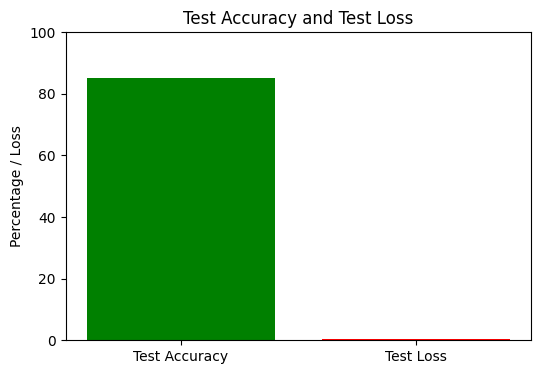

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Plotting test accuracy and test loss
labels = ['Test Accuracy', 'Test Loss']
values = [test_acc * 100, test_loss]  # For better readability

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['green', 'red'])
plt.ylabel('Percentage / Loss')
plt.title('Test Accuracy and Test Loss')
plt.ylim(0, 100)  # Set y-axis limit for percentage comparison
plt.show()

In conclusion, the model does not seem to suffer from underfitting or overfitting because the value of the accuracies seems to be correct. Adding data augmentation improves the model performance (0.775 val_accu without data augmentation versus 0.7825 val_accu with data augmentation). At the same time, the pre-trained VGG16 seems to perform better than the previous implementation, as its accuracy is 85 % using the test data set. An 85% accuracy means that the model classifies correctly 85% of the time.

## Third problem: *Image Classification 2*

Download the CIFAR-10 dataset and load the pickled data into your program.

train_images shape: (50000, 32, 32, 3)
train_labels shape: (50000, 1)
x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


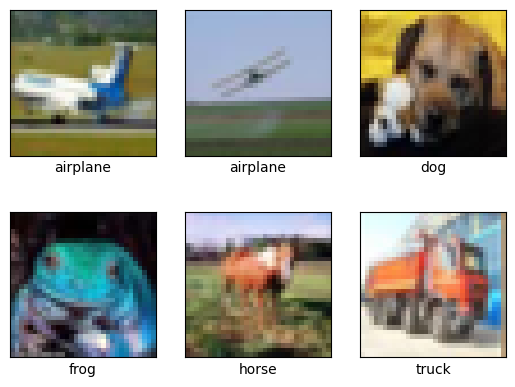

In [38]:
# Load the dataset
(train_images, train_labels), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, x_test = train_images / 255.0, x_test / 255.0

# Split the training data into training and validation sets
x_train,x_val,y_train,y_val = train_test_split(train_images,train_labels,test_size=0.2)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# ------------------------------------------------------------------------------
#       VALIDATIONS
# ------------------------------------------------------------------------------

print(f'train_images shape: {train_images.shape}')
print(f'train_labels shape: {train_labels.shape}')
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

# Visualization
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(labels[y_train[i][0]])
plt.show()

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

Build a basic CNN with several convolution blocks, where each block includes convolutiom, pooling, and normalization layers. Flatten the output and pass it through a dense layer that uses softmax activation. Evaluate the model on the validation set.

In [39]:
# Define the input layer
input_tensor = Input(shape=(32, 32, 3))

# Convolutional Layer 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Convolutional Layer 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Convolutional Layer 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten and Dense layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
output_tensor = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
history = model.fit(
    x_train,
    y_train,
    epochs=5,                                              # Number of epochs to train
    validation_data=(x_val, y_val),                         # Use the non-augmented validation set
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 209s 164ms/step - accuracy: 0.3794 - loss: 1.9049 - val_accuracy: 0.5168 - val_loss: 1.3227
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 254s 158ms/step - accuracy: 0.5723 - loss: 1.2037 - val_accuracy: 0.4513 - val_loss: 1.7791
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 167s 130ms/step - accuracy: 0.6554 - loss: 0.9857 - val_accuracy: 0.6715 - val_loss: 0.9483
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 199s 128ms/step - accuracy: 0.7013 - loss: 0.8606 - val_accuracy: 0.6406 - val_loss: 1.0704
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 204s 129ms/step - accuracy: 0.7344 - loss: 0.7669 - val_accuracy: 0.6860 - val_loss: 0.9569


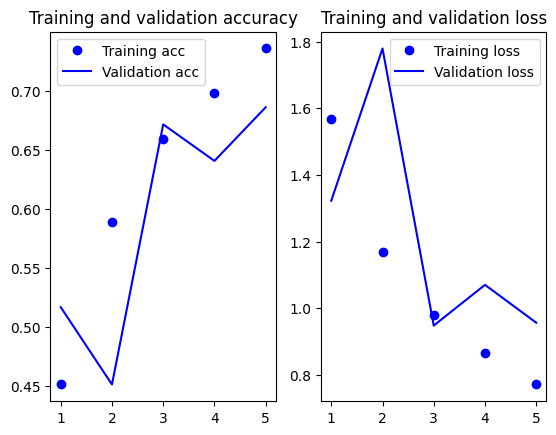

In [43]:
results_model() # Obtain results

Replace the convolution blocks with Inception blocks and test the model's performance

In [41]:
def inception_block(input_tensor, filters):
  # First branch with 1x1 convolution
  brach1x1 = Conv2D(filters[0], (1, 1), activation='relu', padding='same')(x)

  # Second branch with 1x1 and 3x3 convolution
  branch3x3 = Conv2D(filters[1], (1, 1), activation='relu', padding='same')(x)
  brach3x3 = Conv2D(filters[2], (3, 3), activation='relu', padding='same')(brach3x3)

  # Third branch with 1x1 and 5x5 convolution
  branch5x5 = Conv2D(filters[3], (1, 1), activation='relu', padding='same')(x)
  branch5x5 = Conv2D(filters[4], (5, 5), activation='relu', padding='same')(branch5x5)

  # Fourth branch with max pooling and 1x1 convolution
  branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
  branch_pool = Conv2D(filters[5], (1, 1), activation='relu', padding='same')(branch_pool)

  # Concatenate the outputs of the four branches
  output = concatenate([brach1x1, brach3x3, branch5x5, branch_pool], axis=3)

  return output

In [ ]:
# Define the input tensor
input_tensor = layers.Input(shape=(32, 32, 3))

# First Inception block
x = inception_block(input_tensor, filters=[64, 96, 128, 32, 16, 32])
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

# Second Inception block
x = inception_block(x, filters=[128, 128, 192, 96, 48, 64])
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

# Flatten the output
x = Flatten()(x)

# Dense layer
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)

# Output layer
output_tensor = Dense(10, activation='softmax')(x) # 10 different classes

# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

model.compile(optimizer='rmsprop', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

In [ ]:
train_generator = ImageDataGenerator()
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2210s 2s/step - accuracy: 0.4796 - loss: 1.6096 - val_accuracy: 0.6381 - val_loss: 1.0612
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2167s 2s/step - accuracy: 0.7163 - loss: 0.8160 - val_accuracy: 0.6906 - val_loss: 0.9009
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2205s 2s/step - accuracy: 0.8098 - loss: 0.5467 - val_accuracy: 0.7119 - val_loss: 0.9117
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2211s 2s/step - accuracy: 0.8830 - loss: 0.3388 - val_accuracy: 0.7230 - val_loss: 0.9781
Epoch 5/5
  93/1250 ━━━━━━━━━━━━━━━━━━━━ 31:33 2s/step - accuracy: 0.9280 - loss: 0.1996

My colab session ran out because the model spent too much time training. However, the results of the model are good. The model correctly classifies 72,3% of the validation images and fits the training set perfectly (92%)

In [ ]:
results_model() # I could not run it because my colab session closed and I did not have enough time to retry

Replace the Inception blocks with residual blocks and test the model's performance.

In [44]:
def resnet_block(inputs,num_filters,kernel_size,strides):

    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Add the input to the output of the second convolution layer
    res = Add()([inputs, x])
    out= Activation('relu')(res)

    return out

In [45]:
def resnet(input_shape, num_classes, num_filters, kernel_size, strides, num_blocks):
    inputs = Input(shape=input_shape)

    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for i in range(num_blocks):
        x = resnet_block(x, num_filters, kernel_size, strides)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = resnet(input_shape=(32, 32, 3), num_classes=10, num_filters=64, kernel_size=3, strides=1, num_blocks=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train,
                    y_train,
                    epochs=5,
                    validation_data=(x_val, y_val))

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2045s 2s/step - accuracy: 0.3884 - loss: 1.6621 - val_accuracy: 0.4261 - val_loss: 1.7421
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2006s 2s/step - accuracy: 0.5860 - loss: 1.1645 - val_accuracy: 0.4785 - val_loss: 1.4531
Epoch 3/5
 266/1250 ━━━━━━━━━━━━━━━━━━━━ 25:45 2s/step - accuracy: 0.6429 - loss: 1.0024

I got the same problem, my Colab ran out and I dont have time to retry. However, Their result are not the best and I think that the accuracy will not improve a lot with more training.

Evaluate the algorithm and report results.

In [ ]:
# Evaluate the model on test data (I must have already trained the model before this step)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}')